## Predictive Modeling: Using Regression models to predict price of used cars.
This project aims to show the process of creating Machine Learning models based on Simple, Multiple and Polynomial Regresisons.
In this project, R2 is used to evaluate the performance of the models. Pearson Coeficient's P-Value of <= 0.05 rejects the null hypotesis.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
def PrepData(pathfile,carmodelname,target): ##remove nulls in price
    df = pd.read_csv(pathfile)
    df = df[df['model_name'].isin([carmodelname])].reset_index(drop=True).drop(['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','duration_listed','engine_has_gas','engine_type','has_warranty','is_exchangeable','location_region','number_of_photos','body_type','up_counter','feature_0','manufacturer_name','model_name'],axis=1)
    TargetVar = df[target]
    df.drop(columns=[target], axis=1,inplace=True)
    df.insert(0,target, TargetVar)
    dfobject = df.select_dtypes(include='object')
    df = df.select_dtypes(exclude='object')
    return dfobject, df

def Dummies(df):
    return pd.concat([df, pd.get_dummies(df[list(df)])],axis=1).drop(df[list(df)],axis=1)

def ReadyData(dfnumeric,dfnonnumeric):
    return pd.merge(dfnumeric,Dummies(dfnonnumeric),left_index=True,right_index=True)

def BoxplotObjects(df,dftarget): ## Show counts on plot ##better show car colors
    fig, axs = plt.subplots(ncols=len(list(df)), figsize=(16,4),sharey=True)
    t = 0
    for c in list(df):
        sns.boxplot(x=df[c],y=dftarget[Y],data=df, ax=axs[t])
        t += 1
    return

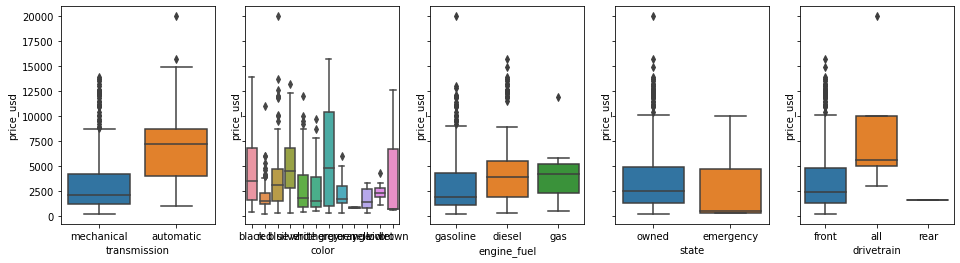

In [3]:
pf = 'C:/Users/Gfreitas/Downloads/ModeloPreditivoCarrosUsados/cars.csv' #pathfile of the dataset
carmodel = 'Golf' # Car model to predict
Y = 'price_usd' # Y is the name of the column with dependent (target) variable
dfobj, dfnum = PrepData(pf,carmodel,Y)
BoxplotObjects(dfobj, dfnum)
cardf = ReadyData(dfnum, dfobj)

In [4]:
def CoefPearson(df):
    lcoef = []
    lp = []
    for col in list(df.columns):
        coef, p = stats.pearsonr(df[col],df[Y])
        lcoef.append(coef)
        lp.append(round(p,3))
    return pd.DataFrame(lcoef).merge(pd.DataFrame(lp),on=df.columns).rename(columns={'key_0':'IndependentVar','0_x':'PearsonCoef','0_y':'P-Value'}).drop([0]).reset_index(drop=True)

def NLargAbsCoef(df,n): # list of absolute nlargest pearson coefs
    df = CoefPearson(df)
    df = df[df['P-Value'] <= 0.05].reset_index(drop=True).loc[df['PearsonCoef'].abs().nlargest(n,keep='first').index]
    return list(df['IndependentVar'])

Simple Linear Regression Model Equation:
 -687740.0671526314 + 346.0436035430563 * price_usd


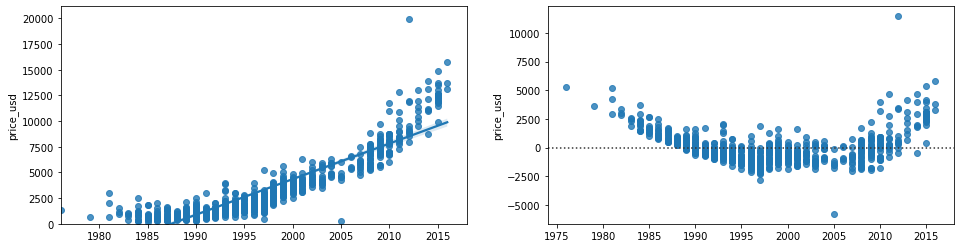

In [5]:
#Simple Linear Regression + Residual Plot
##Create plot function
xBestIndVar = NLargAbsCoef(cardf,1)
TargetVar = cardf[Y]
X = cardf[[xBestIndVar[0]]].values
lm = LinearRegression().fit(X,TargetVar)
fig, axs = plt.subplots(ncols=2, figsize=(16,4))
ax0 = sns.regplot(x=X,y=TargetVar,data=cardf,ax=axs[0])
ax1 = sns.residplot(x=X,y=TargetVar,data=cardf,ax=axs[1])
ax0.set_ylim(0,)
ax0.set_xlim(X.min(),)
print('Simple Linear Regression Model Equation:\n',lm.intercept_,'+',float(lm.coef_),'*',Y)
#Residual plot shows that linear regression is not a good model (curvy residual)

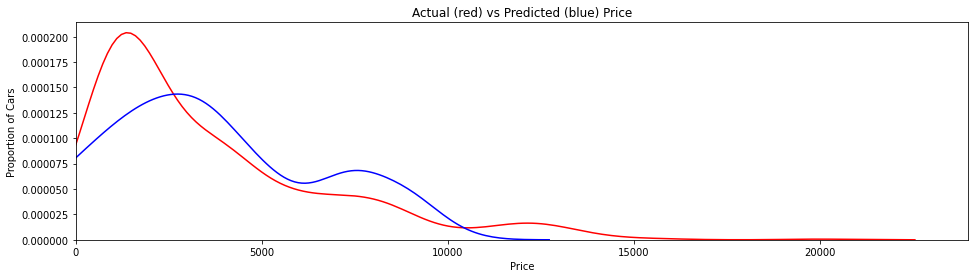

Intercept: -667827.9087104949
Coefs: [336.2213041930617, 381.4118570332788, -381.4118570332788]


In [6]:
#Regressão Linear Múltipla
##better show coef and intercept (table?)
##improve selection of best independent variables (hypermeram?)
Z = cardf[NLargAbsCoef(cardf,3)].values #Z is the selection of independent variable columns
lm1 = LinearRegression().fit(Z,TargetVar)
##Create plot function
plt.figure(figsize=(16,4))
ax1 = sns.kdeplot(TargetVar, color="r", label="Actual Value")
sns.kdeplot(lm1.predict(Z), color="b", label="Predicted Values", ax=ax1)
plt.title('Actual (red) vs Predicted (blue) Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')
plt.xlim(0,)
plt.show()
plt.close()
print("Intercept:",lm1.intercept_)
print("Coefs:",list(lm1.coef_))

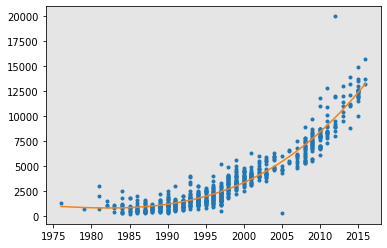

Polynomial Regression Model Equation:
         3        2
0.1785 x - 1056 x + 2.084e+06 x - 1.371e+09


In [7]:
#Polynomial Regression Plotting
def PlotPR(model, dvar):
    x_new = np.linspace(dvar.min(),dvar.max())
    y_new = model(x_new)
    plt.plot(dvar, TargetVar, '.', x_new, y_new, '-')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.show()
    plt.close()
x = cardf[xBestIndVar[0]].values
p = np.poly1d(np.polyfit(x, TargetVar, 3)) #3 degrees polynomial. Adjust to be selectable and be ready for hyperparameters
PlotPR(p, x)
print('Polynomial Regression Model Equation:\n',p)

In [8]:
#R2 calculation and comparison
def R2(realY,predictY):
    return r2_score(realY,predictY)

def ModelComparison():
    md = ['Simple Linear Regression','Multiple Linear Regression','Polynomial Regression']
    preds = [lm.predict(X),lm1.predict(Z),p(x)]
    bestr2 = 0
    for pred, q in zip(list(preds), md):
        r2 = R2(TargetVar,pred)
        print(q,'R2:',r2)
        if r2 > bestr2:
            bestr2 = r2
            bestq = q
    return print('Best model by R2 is',bestq,'with R2 of',bestr2)

In [9]:
ModelComparison()

Simple Linear Regression R2: 0.8134058215471239
Multiple Linear Regression R2: 0.8188011144415942
Polynomial Regression R2: 0.9202584402467222
Best model by R2 is Polynomial Regression with R2 of 0.9202584402467222


In [10]:
#Predictions
def SLR_Pred(model,independent_variable):
    return round((float(model.predict([[independent_variable]]))),2)

def MLR_Pred(model,independent_variable):
    return round(float(model.predict([independent_variable])),2)

def PR_Pred(model,independent_variable):
    return round(model(independent_variable),2)

In [11]:
#Prediction Example
#input()
MLR_Var = [2010,0,1] #get it from user input, showing the independent variables names
Var = 2010 #get it from user input, showing the independent variable name
print('SLR predicted price:',SLR_Pred(lm,Var))
print('MLR predicted price:',MLR_Pred(lm1,MLR_Var))
print('RP predicted price:',PR_Pred(p,Var))

SLR predicted price: 7807.58
MLR predicted price: 7595.5
RP predicted price: 8356.24
